## Importing the libraries

Load required libraries for modeling and data processing

In [1]:
import numpy as np
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

np.random.seed(0)

Helper functions to load and split train and test data

In [7]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [8]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


## Explore the data




In this dataset we have the following 9 features:


1.   Total Acceleration x
2.   Total Acceleration y
3.   Total Acceleration z
4.   Body Acceleration x
5.   Body Acceleration y
6.   Body Acceleration z
7.   Body Gyroscope x
8.   Body Gyroscope y
9.   Body Gyroscope z


In [9]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()

(470528, 9)


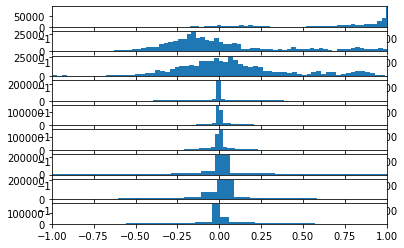

In [10]:
# plot distributions
plot_distributions(trainX)

We can see that all variables except "Total Acceleration x" behave like normal distributions. 

## Building the models

1.   LSTM model
2.   CNN model



In [11]:
batch_size = 64
validation_split = 0.2

### LSTM model

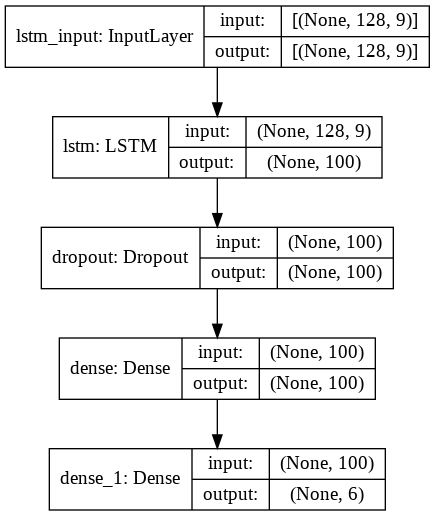

In [12]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Train the model

In [14]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 15s 143ms/step - loss: 1.2396 - accuracy: 0.4703 - val_loss: 1.0881 - val_accuracy: 0.5683
Epoch 2/10
92/92 [==============================] - 13s 138ms/step - loss: 0.8851 - accuracy: 0.6179 - val_loss: 0.8125 - val_accuracy: 0.6995
Epoch 3/10
92/92 [==============================] - 13s 136ms/step - loss: 0.6513 - accuracy: 0.7244 - val_loss: 0.7066 - val_accuracy: 0.7084
Epoch 4/10
92/92 [==============================] - 13s 136ms/step - loss: 0.5234 - accuracy: 0.7808 - val_loss: 0.6525 - val_accuracy: 0.7505
Epoch 5/10
92/92 [==============================] - 13s 137ms/step - loss: 0.4170 - accuracy: 0.8329 - val_loss: 0.6018 - val_accuracy: 0.8355
Epoch 6/10
92/92 [==============================] - 13s 140ms/step - loss: 0.3088 - accuracy: 0.8924 - val_loss: 0.4195 - val_accuracy: 0.8729
Epoch 7/10
92/92 [==============================] - 13s 138ms/step - loss: 0.2469 - accuracy: 0.9165 - val_loss: 0.4262 - val_accuracy: 0.8844

Visualize the training process (loss) w.r.t train set and the validation set

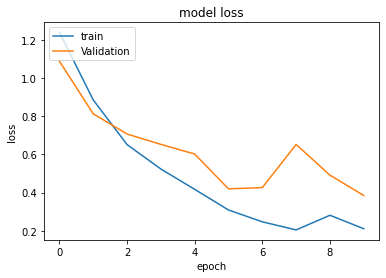

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

Evaluate the LSTM model

In [16]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the LSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the LSTM model 0.9060060977935791


In [17]:
predictions

array([[9.94780660e-03, 1.74025481e-03, 1.80735995e-04, 2.89295502e-02,
        9.59147811e-01, 5.38158311e-05],
       [4.75523947e-03, 7.55980785e-04, 7.94838634e-05, 2.31725778e-02,
        9.71207857e-01, 2.88725169e-05],
       [4.66633588e-03, 6.73362345e-04, 7.19516029e-05, 2.12378930e-02,
        9.73325074e-01, 2.54648548e-05],
       ...,
       [2.94994982e-03, 9.94821310e-01, 2.16431264e-03, 2.89978125e-05,
        3.44588479e-05, 7.72684416e-07],
       [5.38322190e-03, 9.93373036e-01, 9.26533598e-04, 1.06245985e-04,
        2.03786651e-04, 7.25348673e-06],
       [7.14985467e-03, 9.91910517e-01, 5.25589043e-04, 8.67238050e-05,
        3.19923362e-04, 7.43317196e-06]], dtype=float32)

helper function to display results

In [18]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[470   9  17   0   0   0]
 [ 14 434  22   0   1   0]
 [  2   0 418   0   0   0]
 [  0   9   0 361 121   0]
 [  5   2   0  48 477   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.96      0.95      0.95       496
           2       0.90      0.92      0.91       471
           3       0.91      1.00      0.95       420
           4       0.88      0.74      0.80       491
           5       0.80      0.90      0.84       532
           6       1.00      0.95      0.97       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



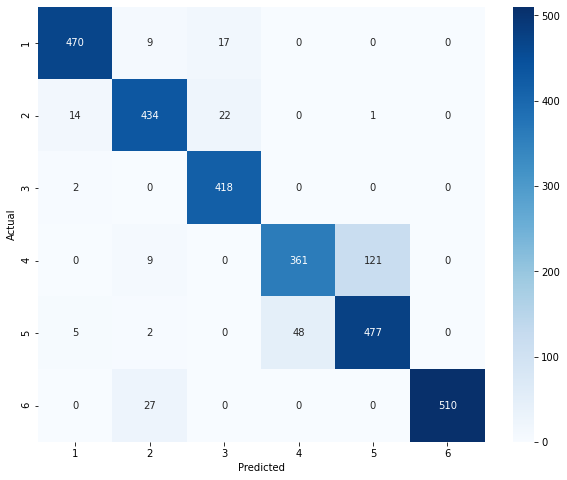

In [19]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

1. WALKING
2. WALKING_UPSTAIRS
3. WALKING_DOWNSTAIRS
4. SITTING
5. STANDING
6. LAYING

### CNN model

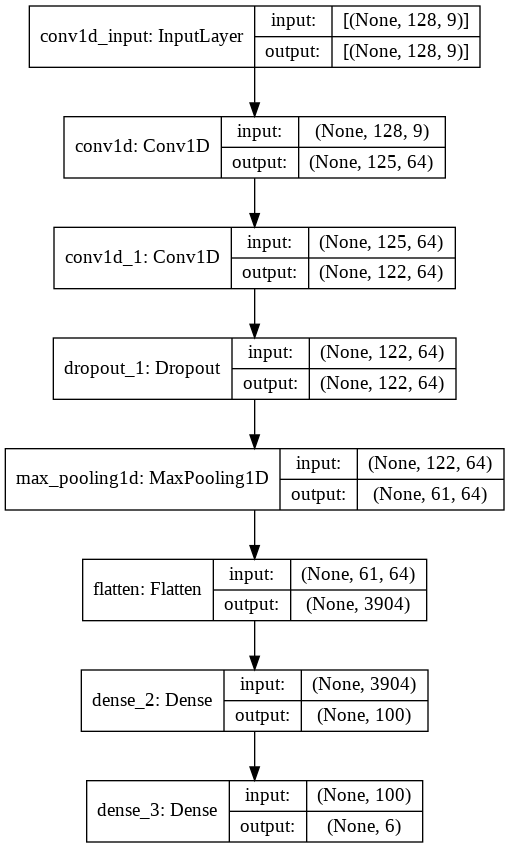

In [20]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Train the model

In [22]:
# fit network
train_epochs = 20
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/20
92/92 [==============================] - 5s 52ms/step - loss: 0.4914 - accuracy: 0.8000 - val_loss: 0.3314 - val_accuracy: 0.8933
Epoch 2/20
92/92 [==============================] - 5s 49ms/step - loss: 0.1462 - accuracy: 0.9418 - val_loss: 0.2981 - val_accuracy: 0.9096
Epoch 3/20
92/92 [==============================] - 5s 49ms/step - loss: 0.1097 - accuracy: 0.9563 - val_loss: 0.3355 - val_accuracy: 0.9103
Epoch 4/20
92/92 [==============================] - 4s 49ms/step - loss: 0.1004 - accuracy: 0.9561 - val_loss: 0.3533 - val_accuracy: 0.9089
Epoch 5/20
92/92 [==============================] - 4s 48ms/step - loss: 0.0875 - accuracy: 0.9607 - val_loss: 0.4110 - val_accuracy: 0.9096
Epoch 6/20
92/92 [==============================] - 4s 49ms/step - loss: 0.0862 - accuracy: 0.9600 - val_loss: 0.4399 - val_accuracy: 0.9109
Epoch 7/20
92/92 [==============================] - 4s 48ms/step - loss: 0.0798 - accuracy: 0.9609 - val_loss: 0.4660 - val_accuracy: 0.9103
Epoch 8/20
92

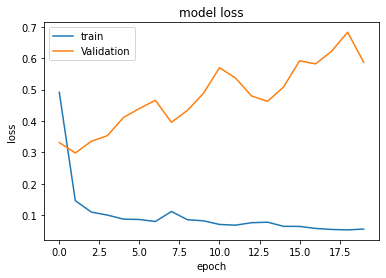

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

Evaluate the LSTM model

In [24]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(testX)

Accuracy of the CNN model 0.8988802433013916


**** Confusion Matrix ****
[[433  18  37   7   1   0]
 [  3 443  25   0   0   0]
 [  1   1 418   0   0   0]
 [  0   6   0 413  71   1]
 [  0   1   0  90 441   0]
 [  0  36   0   0   0 501]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.99      0.87      0.93       496
           2       0.88      0.94      0.91       471
           3       0.87      1.00      0.93       420
           4       0.81      0.84      0.83       491
           5       0.86      0.83      0.84       532
           6       1.00      0.93      0.96       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



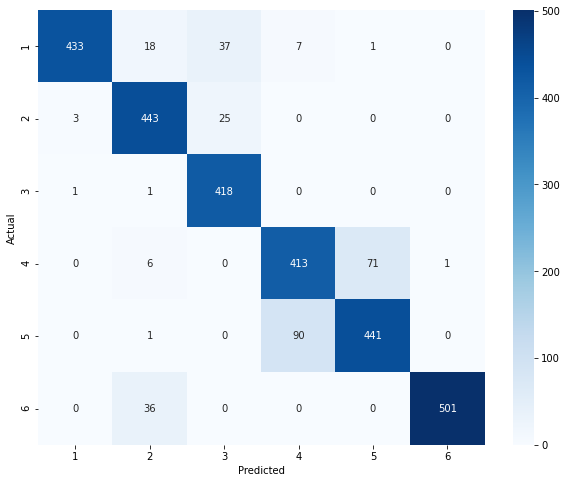

In [25]:
display_results(testy,predictions,classNames)

1. WALKING
2. WALKING_UPSTAIRS
3. WALKING_DOWNSTAIRS
4. SITTING
5. STANDING
6. LAYING

Predicting for a single sample

In [26]:
# we will select the first sample from the test set
sample = testX[0]
sample.shape

(128, 9)

In [27]:
# predict the results using the model, we need to input in the form of (numberOfSamples,featureLength,numberOfFeatures)
predictionForSample = model.predict(sample.reshape(1,sample.shape[0],sample.shape[1]))

In [28]:
# get the class of the sample
samplePredictedClass = np.argmax(predictionForSample, axis=1)
sampleActualClass = np.argmax(testy, axis=1)
print("Actual class: ",sampleActualClass[0])
print("Predicted class: ",samplePredictedClass[0])

Actual class:  4
Predicted class:  4
